# **LB1 project**

The following script allows to evaluate and visualize the performace of a hmm classifier using a set of specified E-value thresholds. You need to pass the output of hmmsearch (.txt) and a file containing only the positive test-set (.fasta).


NB: the output file of hmmsearch has to be previously modify to keep only the id and the E-value in every line (separated by one or more spaces).

e.g.,

" A0A6P8HC43 1e-27

Q28864 2.1e-28

Q02445 3e-27

O54819 3.7e-27

Q03610 3.7e-20

P83606 1e-22

Q7YRQ8 6e-27

Q6T269 3.9e-26 "



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, roc_curve, auc

!pip install biopython
from Bio import SeqIO

In [2]:
def extract_id(fasta_file):
  ''' takes a fasta file as input and returns a list containing only the id'''

  sequences = SeqIO.parse(fasta_file, "fasta") 
  id_list = []

  for record in sequences:
      aux = (record.id).split('|')[1]
      id_list.append(aux)
  return id_list

In [3]:
def assign_labels_predictions(hmmsearch_txt,positives_fasta,threshold):
  ''' takes a txt file containing only one id and E-value divided by a space in each lineas, the fasta file with the sequences of the positive set and a value for the threshold as inputs. 
  It eturns a list containing the true labels, a list containing the predictions, a list containing the false positive ids and a list containing the false negative ids.'''
  
  new_output = [] 
  with open(hmmsearch_txt, 'r') as output:
    for line in output:
      aux = line.split()
      new_output.append([aux[0],float(aux[1])])
  
  id_list = extract_id(positives_fasta)

  labels = [] 
  predictions = []
  fp_ids = []
  fn_ids = []


  for row in new_output: # assign the true label
    if row[0] in id_list:
      true = 1
    else:
      true = 0
    labels.append(true)

    if row[1] < threshold: # make the classification based on the threshold
      pred = 1
    else:
      pred = 0
    predictions.append(pred)

    if true == 0 and pred == 1: # save false positives/negatives
      fp_ids.append(row[0])
    elif true == 1 and pred == 0:
      fn_ids.append(row[0])

  return (labels,predictions,fp_ids,fn_ids)

In [11]:
def score_summary(hmmsearch_txt,positives_fasta,thresholds_list):
  '''returns a dataframe containing various evaluation scores in each column and the E-value threshold used in each row'''

  scores_summary = pd.DataFrame(columns=['threshold', 'cm', 'mcc', 'f1', 'auc', 'accuracy', 'precision', 'recall','tpr', 'fpr', 'fp_ids', 'fn_ids'])

  for threshold in thresholds_list:

    labels, predictions, fp_ids, fn_ids = assign_labels_predictions(hmmsearch_txt,positives_fasta,threshold)
    cm = confusion_matrix(labels, predictions)
    fpr, tpr, thresholds = roc_curve(labels, predictions)

    scores = {'cm': cm,
              'mcc': matthews_corrcoef(labels, predictions),
              'precision': precision_score(labels, predictions, average='binary'),
              'recall': recall_score(labels, predictions, average='binary'),
              'f1': f1_score(labels, predictions, average='binary'),
              'accuracy': accuracy_score(labels, predictions),
              'auc': auc(fpr,tpr),
              'fpr': fpr,
              'tpr': tpr,
              'fp_ids': fp_ids,
              'fn_ids': fn_ids}

    scores['threshold'] = str(threshold)
    scores_summary = scores_summary.append(scores, ignore_index=True)

  return scores_summary

## **Model Evaluation**

In [69]:
%%capture

hmmsearch_txt = 'hmmsearch_test_pfam_final.txt'
positives_fasta = 'filtered_positive.fasta'

thresholds_list = []
for exponent in range(5, 12): #generate a list of thresholds 
    power = 10 ** -exponent
    thresholds_list.append(power)

scores_summary = score_summary(hmmsearch_txt,positives_fasta,thresholds_list) #input_fasta,

In [70]:
scores_summary.head()

,threshold,cm,mcc,f1,auc,accuracy,precision,recall,tpr,fpr,fp_ids,fn_ids
0,1e-05,"[[569112, 14], [0, 374]]",0.981781,0.981627,0.999988,0.999975,0.963918,1.000000,"[0.0, 1.0, 1.0]","[0.0, 2.459912216275482e-05, 1.0]","[Q8WPG5, P84555, P56409, Q09JW3, C5H8E7, Q09JW...",[]
1,1e-06,"[[569117, 9], [1, 373]]",0.986819,0.986772,0.998655,0.999982,0.976440,0.997326,"[0.0, 0.9973262032085561, 1.0]","[0.0, 1.5813721390342386e-05, 1.0]","[Q8WPG5, P84555, P56409, Q09JW3, C5H8E7, Q09JW...",[D3GGZ8]
2,1e-07,"[[569120, 6], [2, 372]]",0.989369,0.989362,0.997321,0.999986,0.984127,0.994652,"[0.0, 0.9946524064171123, 1.0]","[0.0, 1.0542480926894923e-05, 1.0]","[Q8WPG5, P84555, P56409, Q09JW3, C5H8E7, Q09JW4]","[O62247, D3GGZ8]"
3,1e-08,"[[569125, 1], [2, 372]]",0.995982,0.995984,0.997325,0.999995,0.997319,0.994652,"[0.0, 0.9946524064171123, 1.0]","[0.0, 1.7570801544824872e-06, 1.0]",[P84555],"[O62247, D3GGZ8]"
4,1e-09,"[[569126, 0], [3, 371]]",0.995979,0.995973,0.995989,0.999995,1.000000,0.991979,"[0.0, 0.9919786096256684, 1.0]","[0.0, 0.0, 1.0]",[],"[P86963, O62247, D3GGZ8]"


In [6]:
scores_summary.to_csv('hmmsearch_cv2_pfam_final.csv', index=False)

*  **Take only the scores of interest for the report**

In [71]:
%%capture 
n_fp = []
for i, row in scores_summary['fp_ids'].iteritems():
  n_fp.append(len(row))

n_fn = []
for i, row in scores_summary['fn_ids'].iteritems():
  n_fn.append(len(row))

scores_report = scores_summary[['threshold','mcc','f1','auc','accuracy','precision','recall','fp_ids','fn_ids']]
scores_report['fp'] = n_fp
scores_report['fn'] = n_fn

In [72]:
scores_report.to_excel('test_pfam_scores.xlsx')

## **Plots**

In [ ]:
scores_summary = pd.read_csv('hmmsearch_cv1_1bpi+3tgi_final.csv')
scores_summary.head(10) 

<ipython-input-78-f58dc6cf2679>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i,element in thresholds.iteritems():


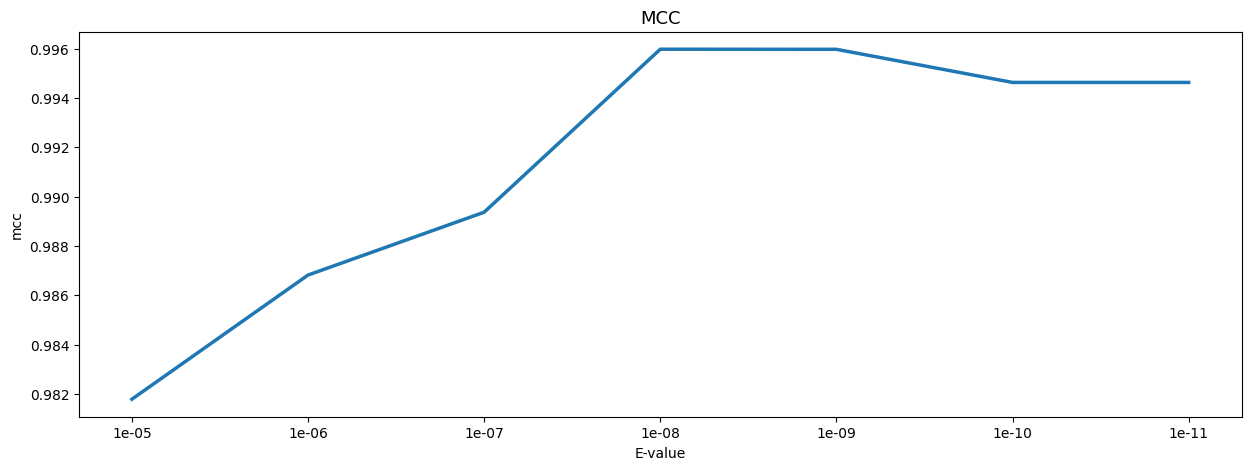

In [78]:
score = 'mcc'

thresholds = scores_summary['threshold']
for i,element in thresholds.iteritems():
  thresholds.at[i] = str(element)
 

plt.figure(figsize=(15, 5)) 
plt.tight_layout() # Ensure the tick labels are not cut off
plt.plot(thresholds,scores_summary[score],linewidth=2.5) #,color='#800080')
plt.xlabel('E-value', fontsize=10)
plt.ylabel(score, fontsize=10)
#plt.xticks(np.arange(0, 42, 2),thresholds)
plt.title(score.upper(), fontsize=13)
plt.show()

*  **ROC Curve**

<ipython-input-77-9aa932dd44a1>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'r--', label='Random model',color='black')  # Plot the diagonal line


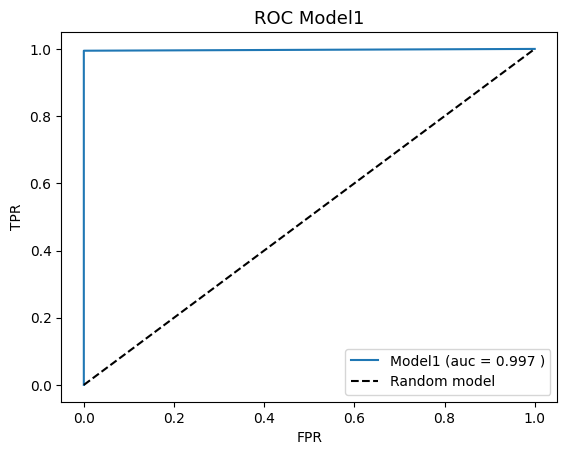

In [77]:
threshold_index = 3

plt.plot(scores_summary.loc[threshold_index,'fpr'], scores_summary.loc[threshold_index,'tpr'], label='Model1 (auc = %s )' % str(scores_summary.loc[threshold_index,'auc'])[0:5]) 
plt.plot([0, 1], [0, 1], 'r--', label='Random model',color='black')  # Plot the diagonal line
plt.xlabel(r'FPR', fontsize=10)
plt.ylabel(r'TPR', fontsize=10)
plt.title(r'ROC Model1', fontsize=13)
plt.legend(loc='lower right')
plt.show()